# Dependence

In [249]:
import torch
import torch.nn as nn
import torch.autograd as autograd

import numpy as np 

from pyDOE import lhs

import matplotlib.pyplot as plt
import matplotlib.tri as mtri

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameter

In [250]:
steps = 10000
layers = np.array([2,32,64,128,64,32,2])
lr = 0.001

Nf = 10000

# Auxiliary Functions


In [251]:
def Plot(V,tris,U):
    _,ax=plt.subplots()
    ax.tripcolor(V[:,0],V[:,1],tris,U,cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('U')
    plt.show()

# Build initial physical mesh

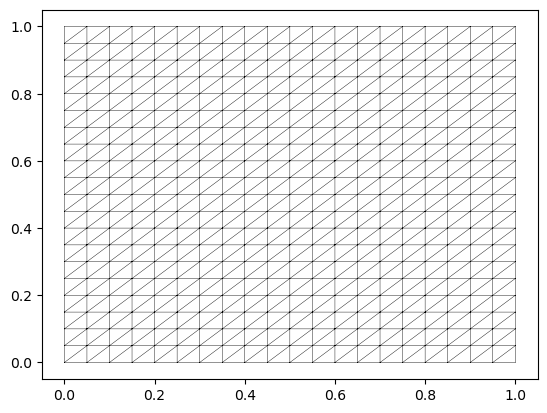

In [252]:
m_rows = 20
m_cols = 20

x = torch.linspace(0, 1, m_cols + 1)
y = torch.linspace(0, 1, m_rows + 1)
x = x.repeat(m_rows + 1)
y = y.repeat_interleave(m_cols + 1)
V = torch.stack([x,y],dim=1)

tris = []

for i in range(m_cols):
   for j in range(m_rows):
       tris.append([j * (m_cols + 1) + i, j * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i + 1])
       tris.append([j * (m_cols + 1) + i, (j + 1) * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i])
        
tris = torch.tensor(tris, dtype=torch.short)

left_boundarys = V[(V[:,0]==0.0)]
bottom_boundarys = V[(V[:,1]==0.0)]
top_boundarys = V[(V[:,1]==1.0)]
right_boundarys = V[(V[:,0]==1.0)]

plt.triplot(x,y,tris,'k-',linewidth=0.3)
plt.show()

# Training Data

In [253]:
left_V = V[(V[:,0]==0.0)]
right_V = V[(V[:,0]==1.0)]
bottom_V = V[(V[:,1]==0.0)]
top_V = V[(V[:,1]==1.0)]

PDE_V = V[0] + (V[-1]-V[0])*lhs(2,Nf)
PDE_V = torch.vstack((left_V,right_V,bottom_V,top_V,PDE_V))
print(PDE_V.shape)

V = V.to(device)
left_V = left_V.float().to(device)
right_V = right_V.float().to(device)
bottom_V = bottom_V.float().to(device)
top_V = top_V.float().to(device)
PDE_V = PDE_V.float().to(device)

torch.Size([10084, 2])


C:\Users\13162\AppData\Local\Temp\ipykernel_39704\932254209.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  PDE_V = V[0] + (V[-1]-V[0])*lhs(2,Nf)


# Functions

In [254]:
def U(V):
    return torch.tanh(-30*(V[:,1]-0.5-0.25*torch.sin(2*torch.pi*V[:,0])))

def U_x_y(V):
    U_x = (1-U(V)**2)*(15*torch.pi*torch.cos(2*torch.pi*V[:,0]))
    U_y = (1-U(V)**2)*(-30)
    return torch.stack([U_x,U_y],dim=1)

def Metric(V):
    u_x_y = U_x_y(V)
    return torch.sqrt(0.1*torch.linalg.norm(u_x_y,dim=1)**2 + 1)

# M = Metric(V)
# Plot(V.detach().cpu(),tris.detach().cpu(),M.detach().cpu())

# Neural Network generates initial logical mesh

$$
\begin{cases}
-\nabla \cdot (\nabla \xi) = 0, \\
\xi|_{\partial \Omega} = \xi_b,
\end{cases}
$$


In [255]:
class FCN1(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers 
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.loss_function2 = nn.L1Loss(reduction ='sum')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)   

    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(self.layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)
        a = self.linears[-1](a)
        return a    
    
    def loss_BC(self,left_V,right_V,bottom_V,top_V):
        return self.loss_function2(self.forward(left_V),left_V) + \
               self.loss_function2(self.forward(right_V),right_V) + \
               self.loss_function2(self.forward(bottom_V),bottom_V) + \
               self.loss_function2(self.forward(top_V),top_V)
              
    def loss_PDE(self,PDE_V):
        g = PDE_V.clone()
        g.requires_grad = True
        xi_eta = self.forward(g)
        xi = xi_eta[:,0].unsqueeze(1)
        eta = xi_eta[:,1].unsqueeze(1)
        xi_x_y = autograd.grad(xi,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        xi_xx_yy = autograd.grad(xi_x_y,g,torch.ones(g.shape).to(device),create_graph=True)[0]
        eta_x_y = autograd.grad(eta,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        eta_xx_yy = autograd.grad(eta_x_y,g,torch.ones(g.shape).to(device),create_graph=True)[0]  
        return self.loss_function(xi_xx_yy[:,[0]]+xi_xx_yy[:,[1]],torch.zeros(g.shape[0],1).to(device)) + \
                self.loss_function(eta_xx_yy[:,[0]]+eta_xx_yy[:,[1]],torch.zeros(g.shape[0],1).to(device))

    def loss(self,left_V,right_V,bottom_V,top_V,PDE_V):      
        return self.loss_PDE(PDE_V) + self.loss_BC(left_V,right_V,bottom_V,top_V)

# Generate initial logic mesh

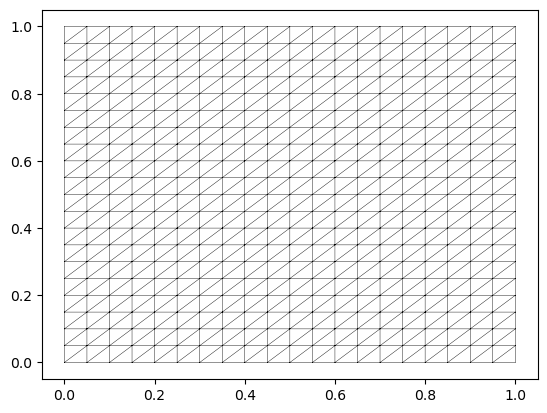

In [256]:
# xi_0 = FCN1(layers).to(device)
# optimizer = torch.optim.Adam(xi_0.parameters(),lr=lr,amsgrad=False)

# for i in range(steps):
#     loss = xi_0.loss(left_V,right_V,bottom_V,top_V,PDE_V)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     print(i,loss.detach().cpu().numpy())
    
# V_xi_0 = xi_0(V)
# V_xi_0_cpu = xi_0(V).detach().cpu()
# plt.triplot(V_xi_0_cpu[:,0],V_xi_0_cpu[:,1],tris.detach().cpu(),'k-',linewidth=0.3)

V_xi_0 = V.clone()
plt.triplot(V_xi_0.detach().cpu()[:,0],V_xi_0.detach().cpu()[:,1],tris.detach().cpu(),'k-',linewidth=0.3)

# Neural Network generate initial physical mesh by solving harmonic maps

$$
g^{ij}\frac{\partial}{\partial \xi^i}w\frac{\partial x^k}{\partial \xi^j} = 0
$$

$$
g^{ij} = \frac{\partial \xi^i}{\partial x^\alpha}\frac{\partial \xi^j}{\partial x^\alpha}
$$


In [257]:
class FCN2(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers 
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.loss_function2 = nn.L1Loss(reduction ='sum')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)   

    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(self.layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)
        a = self.linears[-1](a)
        a[:,[0]] = a[:,[0]]*(x[:,[0]])*(x[:,[0]]-1) + x[:,[0]]
        a[:,[1]] = a[:,[1]]*(x[:,[1]])*(x[:,[1]]-1) + x[:,[1]]
        return a    
    
    def loss_BC(self,left_V,right_V,bottom_V,top_V):
        return self.loss_function2(self.forward(left_V),left_V) + \
               self.loss_function2(self.forward(right_V),right_V) + \
               self.loss_function2(self.forward(bottom_V),bottom_V) + \
               self.loss_function2(self.forward(top_V),top_V)
    
    def loss_PDE(self,PDE_V):
        g = PDE_V.clone()
        g.requires_grad = True
        xy = self.forward(g)
        x = xy[:,[0]]
        y = xy[:,[1]]
        M = Metric(g).unsqueeze(1)
        x_xi_eta = autograd.grad(x,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        y_xi_eta = autograd.grad(y,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        M_xi_eta = autograd.grad(M,g,torch.ones([g.shape[0],1]).to(device),create_graph=True)[0]
        x_xi = x_xi_eta[:,[0]]
        x_eta = x_xi_eta[:,[1]]
        y_xi = y_xi_eta[:,[0]]
        y_eta = y_xi_eta[:,[1]]
        x_xixi_xieta = autograd.grad(x_xi,g,torch.ones([g.shape[0],1]).to(device),create_graph=True)[0]
        x_etaxi_etaeta = autograd.grad(x_eta,g,torch.ones([g.shape[0],1]).to(device),create_graph=True)[0]
        y_xixi_xieta = autograd.grad(y_xi,g,torch.ones([g.shape[0],1]).to(device),create_graph=True)[0]
        y_etaxi_etaeta = autograd.grad(y_eta,g,torch.ones([g.shape[0],1]).to(device),create_graph=True)[0]
        xi_x = y_eta
        xi_y = -x_eta
        eta_x = -y_xi
        eta_y = x_xi
        g00 = xi_x*xi_x+xi_y*xi_y
        g01 = xi_x*eta_x+xi_y*eta_y
        g11 = eta_x*eta_x+eta_y*eta_y
        loss1 = g00*(M_xi_eta[:,[0]]*x_xi_eta[:,[0]]+M*x_xixi_xieta[:,[0]]) + \
                g01*(M_xi_eta[:,[0]]*x_xi_eta[:,[1]]+M*x_etaxi_etaeta[:,[0]]) + \
                g01*(M_xi_eta[:,[1]]*x_xi_eta[:,[0]]+M*x_xixi_xieta[:,[1]]) + \
                g11*(M_xi_eta[:,[1]]*x_xi_eta[:,[1]]+M*x_etaxi_etaeta[:,[1]])
        loss2 = g00*(M_xi_eta[:,[0]]*y_xi_eta[:,[0]]+M*y_xixi_xieta[:,[0]]) + \
                g01*(M_xi_eta[:,[0]]*y_xi_eta[:,[1]]+M*y_etaxi_etaeta[:,[0]]) + \
                g01*(M_xi_eta[:,[1]]*y_xi_eta[:,[0]]+M*y_xixi_xieta[:,[1]]) + \
                g11*(M_xi_eta[:,[1]]*y_xi_eta[:,[1]]+M*y_etaxi_etaeta[:,[1]])
        return self.loss_function(loss1,torch.zeros(g.shape[0],1).to(device)) + \
               self.loss_function(loss2,torch.zeros(g.shape[0],1).to(device))

    def loss(self,left_V,right_V,bottom_V,top_V,PDE_V):      
        return self.loss_PDE(PDE_V)
    

# Generate initial physical mesh

0 15727.707
1 13587.27
2 11741.746
3 10248.402
4 8949.778
5 7780.127
6 6751.7456
7 5852.5703
8 5050.13
9 4323.8535
10 3670.141
11 3089.0986
12 2578.5535
13 2136.9307
14 1765.7041
15 1467.2119
16 1239.8184
17 1075.346
18 963.88684
19 903.9298
20 903.43005
21 960.2375
22 1039.7183
23 1089.2188
24 1082.0857
25 1033.6282
26 974.8974
27 919.5874
28 859.56366
29 787.93085
30 713.27185
31 650.4717
32 607.79364
33 584.08527
34 572.9911
35 567.60034
36 562.9468
37 556.6665
38 548.6525
39 540.20856
40 532.9601
41 527.78076
42 524.12665
43 520.18225
44 513.86523
45 504.10455
46 491.49152
47 477.87457
48 465.31134
49 455.15552
50 447.73776
51 442.58612
52 438.87714
53 435.84155
54 432.9936
55 430.17
56 427.4331
57 424.91205
58 422.6596
59 420.5811
60 418.45752
61 416.04327
62 413.18268
63 409.8833
64 406.30957
65 402.7078
66 399.30548
67 396.23572
68 393.51596
69 391.07782
70 388.82397
71 386.68048
72 384.62277
73 382.6687
74 380.8494
75 379.17627
76 377.6228
77 376.1292
78 374.62683
79 373.0675
8

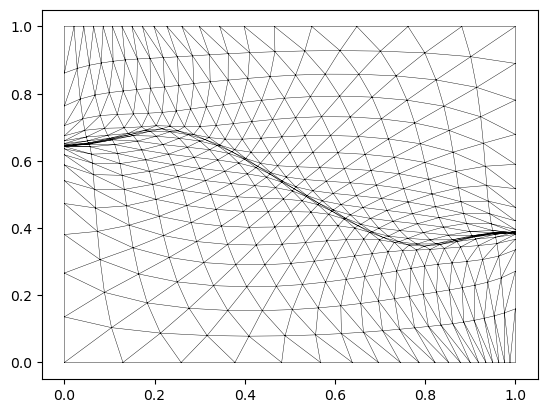

In [258]:
x_new = FCN2(layers).to(device)
optimizer = torch.optim.Adam(x_new.parameters(),lr=lr,amsgrad=False)

for i in range(steps):
    loss = x_new.loss(left_V,right_V,bottom_V,top_V,PDE_V)
    optimizer.zero_grad()
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(xi_new.parameters(), 1.0)
    optimizer.step()
    print(i,loss.detach().cpu().numpy())
    
V_new = x_new(V_xi_0)
plt.triplot(V_new.detach().cpu()[:,0],V_new.detach().cpu()[:,1],tris.detach().cpu(),'k-',linewidth=0.3)

# Update physical mesh

In [259]:
V_new.require_grads = True
xi_x_y = autograd.grad(V_new[:,0].unsqueeze(1),V,torch.ones([V.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
eta_x_y = autograd.grad(V_new[:,1].unsqueeze(1),V,torch.ones([V.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
xi_x,xi_y,eta_x,eta_y = xi_x_y[:,[0]],xi_x_y[:,[1]],eta_x_y[:,[0]],eta_x_y[:,[1]]
delta_V_xi = V_xi_0 - V_new
delta_V_xi_x = delta_V_xi[:,0].unsqueeze(1)
delta_V_xi_y = delta_V_xi[:,1].unsqueeze(1)
delta_V_x = (1/(xi_x*eta_y-xi_y*eta_x)*(eta_y*delta_V_xi_x-xi_y*delta_V_xi_y)).squeeze()
delta_V_y = (1/(xi_x*eta_y-xi_y*eta_x)*(-eta_x*delta_V_xi_x+xi_x*delta_V_xi_y)).squeeze()
delta_V = torch.stack([delta_V_x,delta_V_y],dim=1)
delta_V = delta_V / torch.linalg.norm(delta_V,dim=1).unsqueeze(1)*0.01
delta_V[V[:,0]==0.0] = 0.0
delta_V[V[:,0]==1.0] = 0.0
delta_V[V[:,1]==0.0] = 0.0
delta_V[V[:,1]==1.0] = 0.0

new_V = (V + delta_V).detach().cpu()

plt.triplot(new_V[:,0],new_V[:,1],tris.detach().cpu(),'k-',linewidth=0.3)
plt.show()

RuntimeError: One of the differentiated Tensors does not require grad